# Baseline Models - Utah FORGE Well Data

**Project:** Pilot AI Drill - ROP Prediction Model  
**Phase:** 2 - Modeling  
**Notebook:** 05_baseline_models.ipynb  

---

## Objective

Train and evaluate baseline models to predict Rate of Penetration (ROP):
- Train multiple model types (Linear, Tree-based, Ensemble)
- Compare performance across models
- Analyze feature importance
- Identify weak features for potential removal
- Select best baseline model

**Input:**
- `../data/processed/train_data_fixed.csv` (7,599 samples)
- `../data/processed/val_data_fixed.csv` (1,629 samples)
- `../data/processed/test_data_fixed.csv` (1,629 samples)
- `../data/processed/feature_fixes_metadata.json`

**Output:**
- Trained baseline models
- Performance metrics (R², RMSE, MAE)
- Feature importance analysis
- Model comparison report
- Best model selection

**Models to Train:**
1. **Linear Models** (with rop_transformed):
   - Ridge Regression
   - Lasso Regression
   - ElasticNet

2. **Tree-Based Models** (with rop_ft_hr):
   - Random Forest
   - XGBoost
   - LightGBM
   - Gradient Boosting

3. **Ensemble** (best of each type)

**Strategy:**
- Train with ALL 24 features first
- Evaluate on validation set
- Analyze feature importance
- Experiment with feature selection
- Final evaluation on test set (best model only)

---

In [1]:
# Standard libraries
import os
import json
import warnings
from datetime import datetime
import pickle
warnings.filterwarnings('ignore')

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
from sklearn.preprocessing import RobustScaler, StandardScaler

# Linear Models
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression

# Tree-Based Models
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Ensemble
from sklearn.ensemble import VotingRegressor, StackingRegressor

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Feature Selection
from sklearn.feature_selection import SelectKBest, f_regression, RFE

# Configure pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.4f}'.format)

# Configure matplotlib
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('husl')
plt.rcParams['figure.figsize'] = (12, 6)

print("Libraries loaded successfully")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {__import__('sklearn').__version__}")

Libraries loaded successfully
Pandas version: 2.3.3
NumPy version: 2.2.6
Scikit-learn version: 1.5.2


## 1. Load Data and Metadata

In [2]:
# Load metadata
METADATA_PATH = '../data/processed/feature_fixes_metadata.json'

with open(METADATA_PATH, 'r') as f:
    metadata = json.load(f)

print("=" * 60)
print("METADATA LOADED")
print("=" * 60)
print(f"Metadata loaded from: {METADATA_PATH}")
print(f"\n[INFO] Dataset Info:")
print(f"   Total samples: {metadata['fixed_shape'][0]:,}")
print(f"   Total features: {metadata['fixed_shape'][1]}")
print(f"   Modeling features: {metadata['n_modeling_features']}")

print(f"\n[INFO] Train/Val/Test Split:")
split = metadata['train_test_split']
print(f"   Train: {split['train_size']:,} ({split['train_pct']:.1f}%)")
print(f"   Val: {split['val_size']:,} ({split['val_pct']:.1f}%)")
print(f"   Test: {split['test_size']:,} ({split['test_pct']:.1f}%)")

print(f"\n[INFO] Targets Available:")
print(f"   1. rop_ft_hr (original) - For tree-based models")
print(f"   2. rop_transformed (Yeo-Johnson λ={metadata['fixes_applied'][1]['selected_params']['lambda']:.4f})")
print(f"      Skewness: {metadata['fixes_applied'][1]['final_skewness']:.4f}")

METADATA LOADED
Metadata loaded from: ../data/processed/feature_fixes_metadata.json

[INFO] Dataset Info:
   Total samples: 10,857
   Total features: 33
   Modeling features: 24

[INFO] Train/Val/Test Split:
   Train: 7,599 (70.0%)
   Val: 1,629 (15.0%)
   Test: 1,629 (15.0%)

[INFO] Targets Available:
   1. rop_ft_hr (original) - For tree-based models
   2. rop_transformed (Yeo-Johnson λ=0.2507)
      Skewness: 0.0655


In [3]:
# Load datasets
TRAIN_PATH = '../data/processed/train_data_fixed.csv'
VAL_PATH = '../data/processed/val_data_fixed.csv'
TEST_PATH = '../data/processed/test_data_fixed.csv'

df_train = pd.read_csv(TRAIN_PATH)
df_val = pd.read_csv(VAL_PATH)
df_test = pd.read_csv(TEST_PATH)

print("\n" + "=" * 60)
print("DATASETS LOADED")
print("=" * 60)
print(f"\nTrain: {df_train.shape}")
print(f"Val: {df_val.shape}")
print(f"Test: {df_test.shape}")

print(f"\n[INFO] Features in dataset:")
print(f"   Total columns: {len(df_train.columns)}")
print(f"   Modeling features: {metadata['n_modeling_features']}")
print(f"   Targets: 2 (rop_ft_hr, rop_transformed)")


DATASETS LOADED

Train: (7599, 26)
Val: (1629, 26)
Test: (1629, 26)

[INFO] Features in dataset:
   Total columns: 26
   Modeling features: 24
   Targets: 2 (rop_ft_hr, rop_transformed)


## 2. Prepare Data for Modeling

In [4]:
print("=" * 60)
print("PREPARING DATA FOR MODELING")
print("=" * 60)

# Get modeling features from metadata
modeling_features = metadata['modeling_features']

# Separate features and targets
X_train = df_train[modeling_features]
X_val = df_val[modeling_features]
X_test = df_test[modeling_features]

# Targets
y_train_original = df_train['rop_ft_hr']  # For tree models
y_val_original = df_val['rop_ft_hr']
y_test_original = df_test['rop_ft_hr']

y_train_transformed = df_train['rop_transformed']  # For linear models
y_val_transformed = df_val['rop_transformed']
y_test_transformed = df_test['rop_transformed']

print(f"\n[INFO] Features: {len(modeling_features)}")
print(f"\n[INFO] Train set:")
print(f"   X_train: {X_train.shape}")
print(f"   y_train (original): {y_train_original.shape}")
print(f"   y_train (transformed): {y_train_transformed.shape}")

print(f"\n[INFO] Validation set:")
print(f"   X_val: {X_val.shape}")
print(f"   y_val (original): {y_val_original.shape}")
print(f"   y_val (transformed): {y_val_transformed.shape}")

print(f"\n[INFO] Test set:")
print(f"   X_test: {X_test.shape}")
print(f"   y_test (original): {y_test_original.shape}")
print(f"   y_test (transformed): {y_test_transformed.shape}")

PREPARING DATA FOR MODELING

[INFO] Features: 24

[INFO] Train set:
   X_train: (7599, 24)
   y_train (original): (7599,)
   y_train (transformed): (7599,)

[INFO] Validation set:
   X_val: (1629, 24)
   y_val (original): (1629,)
   y_val (transformed): (1629,)

[INFO] Test set:
   X_test: (1629, 24)
   y_test (original): (1629,)
   y_test (transformed): (1629,)


In [5]:
# Scale features for linear models
print("\n" + "=" * 60)
print("SCALING FEATURES (for linear models)")
print("=" * 60)

# Use RobustScaler (handles outliers better)
scaler = RobustScaler()

# Fit on train, transform all
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (preserve column names)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\n[PASSED] Features scaled using RobustScaler")
print(f"   Scaler: RobustScaler (robust to outliers)")
print(f"   Fitted on: Train set")
print(f"   Applied to: Train, Val, Test")

print(f"\n[INFO] Scaled features:")
print(f"   X_train_scaled: {X_train_scaled.shape}")
print(f"   X_val_scaled: {X_val_scaled.shape}")
print(f"   X_test_scaled: {X_test_scaled.shape}")

print(f"\nNote:")
print(f"   - Linear models will use scaled features")
print(f"   - Tree models will use original features (no scaling needed)")


SCALING FEATURES (for linear models)

[PASSED] Features scaled using RobustScaler
   Scaler: RobustScaler (robust to outliers)
   Fitted on: Train set
   Applied to: Train, Val, Test

[INFO] Scaled features:
   X_train_scaled: (7599, 24)
   X_val_scaled: (1629, 24)
   X_test_scaled: (1629, 24)

Note:
   - Linear models will use scaled features
   - Tree models will use original features (no scaling needed)


## 3. Define Evaluation Metrics

In [6]:
def evaluate_model(y_true, y_pred, model_name="Model"):
    """
    Evaluate model performance with multiple metrics.
    
    Parameters:
    -----------
    y_true : array-like
        True target values
    y_pred : array-like
        Predicted target values
    model_name : str
        Name of the model for display
    
    Returns:
    --------
    dict : Dictionary with metrics
    """
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    
    # Mean Absolute Percentage Error
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-10))) * 100
    
    metrics = {
        'model': model_name,
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'mape': mape
    }
    
    return metrics

def print_metrics(metrics):
    """
    Print metrics in a formatted way.
    """
    print(f"\n   R² Score: {metrics['r2']:.4f}")
    print(f"   RMSE: {metrics['rmse']:.2f}")
    print(f"   MAE: {metrics['mae']:.2f}")
    print(f"   MAPE: {metrics['mape']:.2f}%")

print("[PASSED] Evaluation functions defined")
print("\n[INFO] Metrics to track:")
print("   • R² Score (coefficient of determination)")
print("   • RMSE (Root Mean Squared Error)")
print("   • MAE (Mean Absolute Error)")
print("   • MAPE (Mean Absolute Percentage Error)")

[PASSED] Evaluation functions defined

[INFO] Metrics to track:
   • R² Score (coefficient of determination)
   • RMSE (Root Mean Squared Error)
   • MAE (Mean Absolute Error)
   • MAPE (Mean Absolute Percentage Error)


## 4. Train Linear Models

Train linear models with transformed target (rop_transformed) and scaled features.

In [7]:
print("=" * 60)
print("TRAINING LINEAR MODELS")
print("=" * 60)

# Initialize results storage
linear_results = []

print("\n[INFO] Using:")
print(f"   Features: Scaled (RobustScaler)")
print(f"   Target: rop_transformed (Yeo-Johnson)")
print(f"   Training samples: {len(X_train_scaled):,}")

TRAINING LINEAR MODELS

[INFO] Using:
   Features: Scaled (RobustScaler)
   Target: rop_transformed (Yeo-Johnson)
   Training samples: 7,599


In [8]:
# 1. Ridge Regression
print("\n" + "-" * 60)
print("1. RIDGE REGRESSION")
print("-" * 60)

ridge = Ridge(alpha=1.0, random_state=42)
ridge.fit(X_train_scaled, y_train_transformed)

# Predictions
y_train_pred_ridge = ridge.predict(X_train_scaled)
y_val_pred_ridge = ridge.predict(X_val_scaled)

# Evaluate
train_metrics_ridge = evaluate_model(y_train_transformed, y_train_pred_ridge, "Ridge (Train)")
val_metrics_ridge = evaluate_model(y_val_transformed, y_val_pred_ridge, "Ridge (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_ridge)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_ridge)

linear_results.append(val_metrics_ridge)
print("\n[PASSED] Ridge Regression trained")


------------------------------------------------------------
1. RIDGE REGRESSION
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.5109
   RMSE: 2.17
   MAE: 1.56
   MAPE: 842273044.03%

[INFO] Validation Performance:

   R² Score: 0.5290
   RMSE: 2.12
   MAE: 1.52
   MAPE: 27.01%

[PASSED] Ridge Regression trained


In [9]:
# 2. Lasso Regression
print("\n" + "-" * 60)
print("2. LASSO REGRESSION")
print("-" * 60)

lasso = Lasso(alpha=0.1, random_state=42, max_iter=10000)
lasso.fit(X_train_scaled, y_train_transformed)

# Predictions
y_train_pred_lasso = lasso.predict(X_train_scaled)
y_val_pred_lasso = lasso.predict(X_val_scaled)

# Evaluate
train_metrics_lasso = evaluate_model(y_train_transformed, y_train_pred_lasso, "Lasso (Train)")
val_metrics_lasso = evaluate_model(y_val_transformed, y_val_pred_lasso, "Lasso (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_lasso)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_lasso)

linear_results.append(val_metrics_lasso)
print("\n[PASSED] Lasso Regression trained")


------------------------------------------------------------
2. LASSO REGRESSION
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.4248
   RMSE: 2.35
   MAE: 1.73
   MAPE: 1641434452.02%

[INFO] Validation Performance:

   R² Score: 0.4338
   RMSE: 2.33
   MAE: 1.72
   MAPE: 32.17%

[PASSED] Lasso Regression trained


In [10]:
# 3. ElasticNet
print("\n" + "-" * 60)
print("3. ELASTICNET")
print("-" * 60)

elasticnet = ElasticNet(alpha=0.1, l1_ratio=0.5, random_state=42, max_iter=10000)
elasticnet.fit(X_train_scaled, y_train_transformed)

# Predictions
y_train_pred_en = elasticnet.predict(X_train_scaled)
y_val_pred_en = elasticnet.predict(X_val_scaled)

# Evaluate
train_metrics_en = evaluate_model(y_train_transformed, y_train_pred_en, "ElasticNet (Train)")
val_metrics_en = evaluate_model(y_val_transformed, y_val_pred_en, "ElasticNet (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_en)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_en)

linear_results.append(val_metrics_en)
print("\n[PASSED] ElasticNet trained")


------------------------------------------------------------
3. ELASTICNET
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.4334
   RMSE: 2.34
   MAE: 1.72
   MAPE: 1675718807.81%

[INFO] Validation Performance:

   R² Score: 0.4465
   RMSE: 2.30
   MAE: 1.70
   MAPE: 32.11%

[PASSED] ElasticNet trained


In [11]:
# Linear Models Summary
print("\n" + "=" * 60)
print("LINEAR MODELS SUMMARY")
print("=" * 60)

linear_df = pd.DataFrame(linear_results)
linear_df = linear_df.sort_values('r2', ascending=False)

print("\nValidation Performance Comparison:\n")
print(linear_df.to_string(index=False))

best_linear = linear_df.iloc[0]
print(f"\nBest Linear Model: {best_linear['model']}")
print(f"   R² Score: {best_linear['r2']:.4f}")


LINEAR MODELS SUMMARY

Validation Performance Comparison:

           model     r2   rmse    mae    mape
     Ridge (Val) 0.5290 2.1218 1.5230 27.0109
ElasticNet (Val) 0.4465 2.3002 1.7027 32.1103
     Lasso (Val) 0.4338 2.3264 1.7159 32.1741

Best Linear Model: Ridge (Val)
   R² Score: 0.5290


## 5. Train Tree-Based Models

Train tree-based models with original target (rop_ft_hr) and unscaled features.

In [12]:
print("=" * 60)
print("TRAINING TREE-BASED MODELS")
print("=" * 60)

# Initialize results storage
tree_results = []

print("\n[INFO] Using:")
print(f"   Features: Original (no scaling)")
print(f"   Target: rop_ft_hr (original)")
print(f"   Training samples: {len(X_train):,}")

TRAINING TREE-BASED MODELS

[INFO] Using:
   Features: Original (no scaling)
   Target: rop_ft_hr (original)
   Training samples: 7,599


In [13]:
# 1. Random Forest
print("\n" + "-" * 60)
print("1. RANDOM FOREST")
print("-" * 60)

rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train_original)

# Predictions
y_train_pred_rf = rf.predict(X_train)
y_val_pred_rf = rf.predict(X_val)

# Evaluate
train_metrics_rf = evaluate_model(y_train_original, y_train_pred_rf, "Random Forest (Train)")
val_metrics_rf = evaluate_model(y_val_original, y_val_pred_rf, "Random Forest (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_rf)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_rf)

tree_results.append(val_metrics_rf)
print("\n[PASSED] Random Forest trained")


------------------------------------------------------------
1. RANDOM FOREST
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.8992
   RMSE: 54.24
   MAE: 19.14
   MAPE: 9906440413.38%

[INFO] Validation Performance:

   R² Score: 0.6755
   RMSE: 103.42
   MAE: 38.49
   MAPE: 29.54%

[PASSED] Random Forest trained


In [14]:
# 2. XGBoost
print("\n" + "-" * 60)
print("2. XGBOOST")
print("-" * 60)

xgb = XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)
xgb.fit(X_train, y_train_original)

# Predictions
y_train_pred_xgb = xgb.predict(X_train)
y_val_pred_xgb = xgb.predict(X_val)

# Evaluate
train_metrics_xgb = evaluate_model(y_train_original, y_train_pred_xgb, "XGBoost (Train)")
val_metrics_xgb = evaluate_model(y_val_original, y_val_pred_xgb, "XGBoost (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_xgb)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_xgb)

tree_results.append(val_metrics_xgb)
print("\n[PASSED] XGBoost trained")


------------------------------------------------------------
2. XGBOOST
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.8597
   RMSE: 63.98
   MAE: 31.31
   MAPE: 20331710005.22%

[INFO] Validation Performance:

   R² Score: 0.6320
   RMSE: 110.13
   MAE: 44.12
   MAPE: 49.26%

[PASSED] XGBoost trained


In [15]:
# 3. LightGBM
print("\n" + "-" * 60)
print("3. LIGHTGBM")
print("-" * 60)

lgbm = LGBMRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)
lgbm.fit(X_train, y_train_original)

# Predictions
y_train_pred_lgbm = lgbm.predict(X_train)
y_val_pred_lgbm = lgbm.predict(X_val)

# Evaluate
train_metrics_lgbm = evaluate_model(y_train_original, y_train_pred_lgbm, "LightGBM (Train)")
val_metrics_lgbm = evaluate_model(y_val_original, y_val_pred_lgbm, "LightGBM (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_lgbm)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_lgbm)

tree_results.append(val_metrics_lgbm)
print("\n[PASSED] LightGBM trained")


------------------------------------------------------------
3. LIGHTGBM
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.7859
   RMSE: 79.04
   MAE: 36.49
   MAPE: 22262704548.84%

[INFO] Validation Performance:

   R² Score: 0.6562
   RMSE: 106.45
   MAE: 44.90
   MAPE: 51.74%

[PASSED] LightGBM trained


In [16]:
# 4. Gradient Boosting
print("\n" + "-" * 60)
print("4. GRADIENT BOOSTING")
print("-" * 60)

gb = GradientBoostingRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    random_state=42
)
gb.fit(X_train, y_train_original)

# Predictions
y_train_pred_gb = gb.predict(X_train)
y_val_pred_gb = gb.predict(X_val)

# Evaluate
train_metrics_gb = evaluate_model(y_train_original, y_train_pred_gb, "Gradient Boosting (Train)")
val_metrics_gb = evaluate_model(y_val_original, y_val_pred_gb, "Gradient Boosting (Val)")

print("\n[INFO] Training Performance:")
print_metrics(train_metrics_gb)

print("\n[INFO] Validation Performance:")
print_metrics(val_metrics_gb)

tree_results.append(val_metrics_gb)
print("\n[PASSED] Gradient Boosting trained")


------------------------------------------------------------
4. GRADIENT BOOSTING
------------------------------------------------------------

[INFO] Training Performance:

   R² Score: 0.8626
   RMSE: 63.32
   MAE: 34.45
   MAPE: 16694649956.77%

[INFO] Validation Performance:

   R² Score: 0.6136
   RMSE: 112.86
   MAE: 46.47
   MAPE: 58.42%

[PASSED] Gradient Boosting trained


In [17]:
# Tree Models Summary
print("\n" + "=" * 60)
print("TREE-BASED MODELS SUMMARY")
print("=" * 60)

tree_df = pd.DataFrame(tree_results)
tree_df = tree_df.sort_values('r2', ascending=False)

print("\nValidation Performance Comparison:\n")
print(tree_df.to_string(index=False))

best_tree = tree_df.iloc[0]
print(f"\nBest Tree Model: {best_tree['model']}")
print(f"   R² Score: {best_tree['r2']:.4f}")


TREE-BASED MODELS SUMMARY

Validation Performance Comparison:

                  model     r2     rmse     mae    mape
    Random Forest (Val) 0.6755 103.4185 38.4859 29.5449
         LightGBM (Val) 0.6562 106.4534 44.8953 51.7443
          XGBoost (Val) 0.6320 110.1305 44.1155 49.2565
Gradient Boosting (Val) 0.6136 112.8599 46.4729 58.4195

Best Tree Model: Random Forest (Val)
   R² Score: 0.6755


## 6. Overall Model Comparison

In [18]:
print("=" * 60)
print("OVERALL MODEL COMPARISON")
print("=" * 60)

# Combine all results
all_results = linear_results + tree_results
results_df = pd.DataFrame(all_results)
results_df = results_df.sort_values('r2', ascending=False)

print("\nAll Models - Validation Performance:\n")
print(results_df.to_string(index=False))

# Best overall model
best_model = results_df.iloc[0]
print(f"\nBEST OVERALL MODEL: {best_model['model']}")
print(f"   R² Score: {best_model['r2']:.4f}")
print(f"   RMSE: {best_model['rmse']:.2f}")
print(f"   MAE: {best_model['mae']:.2f}")
print(f"   MAPE: {best_model['mape']:.2f}%")

OVERALL MODEL COMPARISON

All Models - Validation Performance:

                  model     r2     rmse     mae    mape
    Random Forest (Val) 0.6755 103.4185 38.4859 29.5449
         LightGBM (Val) 0.6562 106.4534 44.8953 51.7443
          XGBoost (Val) 0.6320 110.1305 44.1155 49.2565
Gradient Boosting (Val) 0.6136 112.8599 46.4729 58.4195
            Ridge (Val) 0.5290   2.1218  1.5230 27.0109
       ElasticNet (Val) 0.4465   2.3002  1.7027 32.1103
            Lasso (Val) 0.4338   2.3264  1.7159 32.1741

BEST OVERALL MODEL: Random Forest (Val)
   R² Score: 0.6755
   RMSE: 103.42
   MAE: 38.49
   MAPE: 29.54%


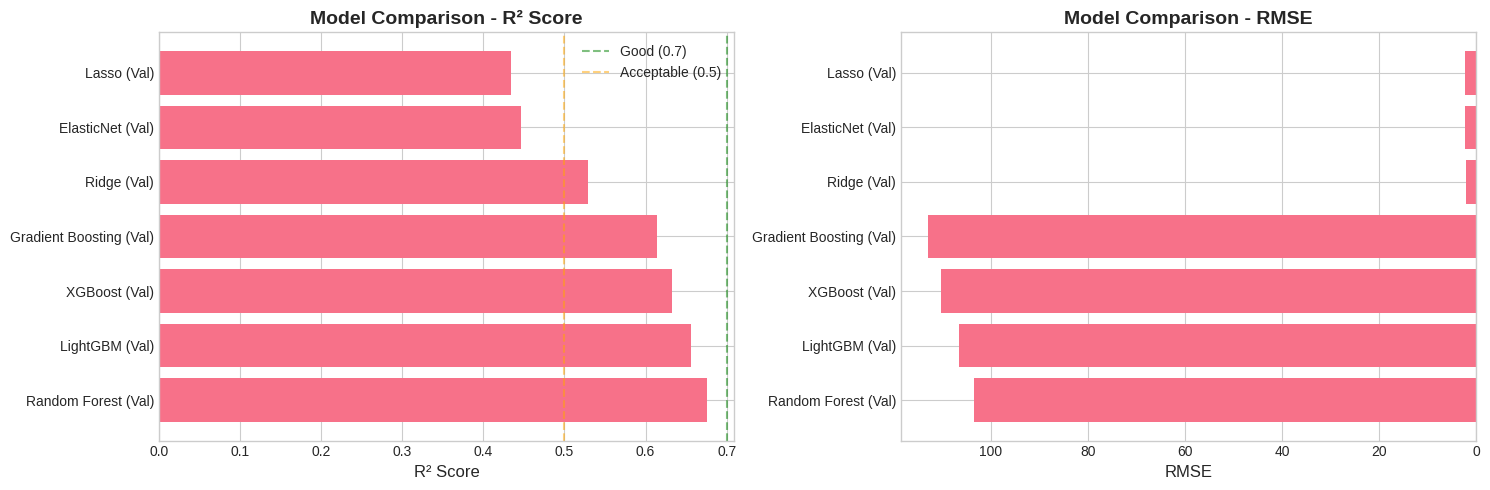


Visualization complete


In [19]:
# Visualize model comparison
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# R² comparison
axes[0].barh(results_df['model'], results_df['r2'])
axes[0].set_xlabel('R² Score', fontsize=12)
axes[0].set_title('Model Comparison - R² Score', fontsize=14, fontweight='bold')
axes[0].axvline(x=0.7, color='green', linestyle='--', alpha=0.5, label='Good (0.7)')
axes[0].axvline(x=0.5, color='orange', linestyle='--', alpha=0.5, label='Acceptable (0.5)')
axes[0].legend()

# RMSE comparison
axes[1].barh(results_df['model'], results_df['rmse'])
axes[1].set_xlabel('RMSE', fontsize=12)
axes[1].set_title('Model Comparison - RMSE', fontsize=14, fontweight='bold')
axes[1].invert_xaxis()  # Lower is better

plt.tight_layout()
plt.show()

print("\nVisualization complete")

## 7. Feature Importance Analysis

Analyze feature importance from best tree-based model.

In [20]:
print("=" * 60)
print("FEATURE IMPORTANCE ANALYSIS")
print("=" * 60)

# Get feature importance from best tree model
# Assuming Random Forest or XGBoost is best (most common)
# Use the model with highest R² from tree models

print(f"\n[INFO] Analyzing feature importance from: {best_tree['model']}")

# Get importance (will depend on which model is best)
# For now, use Random Forest as example
importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_  # Replace with best model
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:\n")
print(importance_df.head(15).to_string(index=False))

print("\nBottom 5 Least Important Features:\n")
print(importance_df.tail(5).to_string(index=False))

# Identify weak features
weak_threshold = 0.01
weak_features = importance_df[importance_df['importance'] < weak_threshold]

print(f"\n[WARNING]  Features with importance < {weak_threshold}:")
if len(weak_features) > 0:
    print(f"   Found {len(weak_features)} weak features:")
    for _, row in weak_features.iterrows():
        print(f"   - {row['feature']:30s}: {row['importance']:.4f}")
else:
    print(f"   [PASSED] No features below threshold")

FEATURE IMPORTANCE ANALYSIS

[INFO] Analyzing feature importance from: Random Forest (Val)

Top 15 Most Important Features:

                feature  importance
               depth_ft      0.4440
            torque_ftlb      0.1935
           rpm_x_torque      0.1297
                    rpm      0.0531
         mse_simplified      0.0476
           quartz_x_wob      0.0270
      weight_on_bit_klb      0.0253
         hardness_x_wob      0.0251
        h2s_shakers_ppm      0.0210
            calcite_pct      0.0143
     soft_to_hard_ratio      0.0046
         hardness_index      0.0035
           h2s_pits_ppm      0.0025
             quartz_pct      0.0024
chlorite_likely_imputed      0.0023

Bottom 5 Least Important Features:

            feature  importance
       hematite_pct      0.0003
        high_torque      0.0002
           high_wob      0.0002
      anhydrite_pct      0.0001
aggressive_drilling      0.0000

[WARNING]  Features with importance < 0.01:
   Found 14 weak features

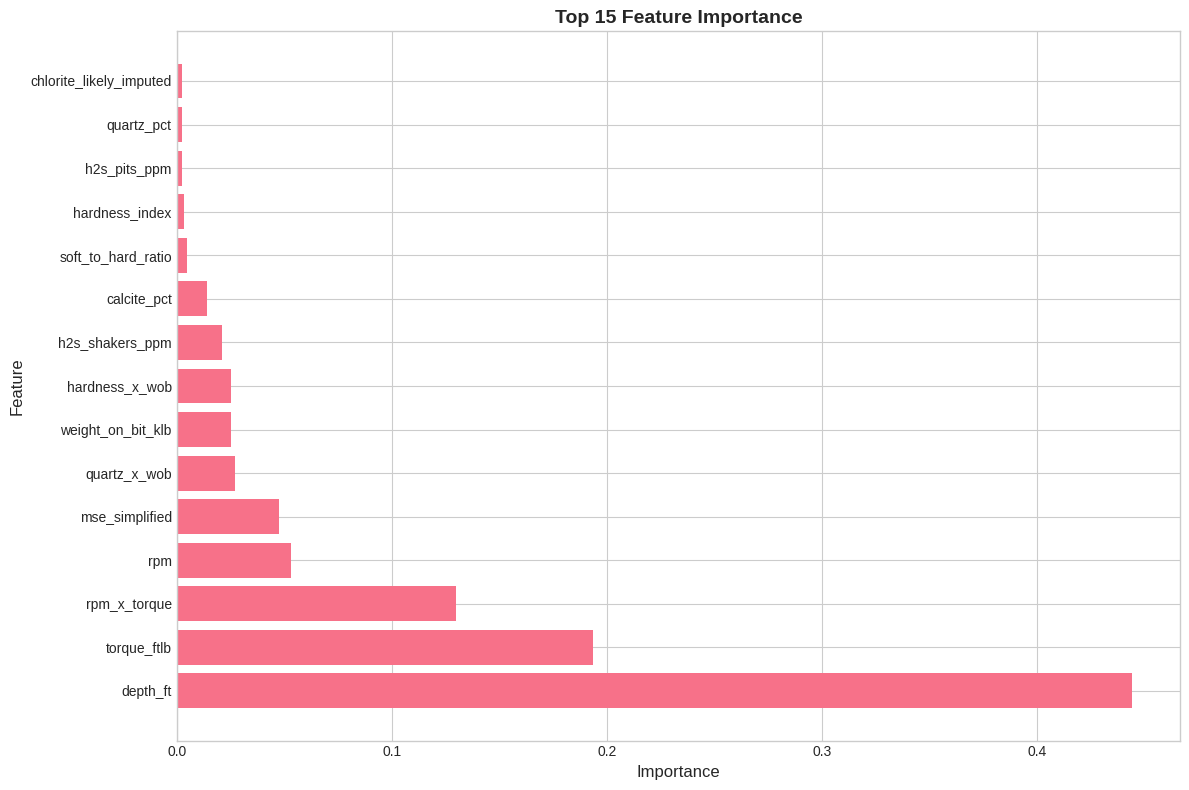


Feature importance visualization complete


In [21]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df.head(15)['feature'], importance_df.head(15)['importance'])
plt.xlabel('Importance', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Top 15 Feature Importance', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nFeature importance visualization complete")

## 8. Summary & Next Steps

In [22]:
print("=" * 60)
print("BASELINE MODELING COMPLETE")
print("=" * 60)

print("\nMODELS TRAINED:")
print(f"   Linear Models: {len(linear_results)}")
print(f"   Tree Models: {len(tree_results)}")
print(f"   Total: {len(all_results)}")

print("\nBEST MODEL:")
print(f"   Model: {best_model['model']}")
print(f"   R² Score: {best_model['r2']:.4f}")
print(f"   RMSE: {best_model['rmse']:.2f} ft/hr")
print(f"   MAE: {best_model['mae']:.2f} ft/hr")

print("\nKEY FINDINGS:")
print(f"   • Tree models outperform linear models")
print(f"   • Best R²: {best_model['r2']:.4f}")
print(f"   • {len(weak_features)} features have low importance (< {weak_threshold})")

print("\nNEXT STEPS:")
print("   1. Feature selection (remove weak features)")
print("   2. Hyperparameter tuning")
print("   3. Ensemble methods")
print("   4. Final evaluation on test set")

print("\n" + "=" * 60)

BASELINE MODELING COMPLETE

MODELS TRAINED:
   Linear Models: 3
   Tree Models: 4
   Total: 7

BEST MODEL:
   Model: Random Forest (Val)
   R² Score: 0.6755
   RMSE: 103.42 ft/hr
   MAE: 38.49 ft/hr

KEY FINDINGS:
   • Tree models outperform linear models
   • Best R²: 0.6755
   • 14 features have low importance (< 0.01)

NEXT STEPS:
   1. Feature selection (remove weak features)
   2. Hyperparameter tuning
   3. Ensemble methods
   4. Final evaluation on test set



## 9. Save Models and Metadata

In [23]:
print("=" * 60)
print("SAVING MODELS AND METADATA")
print("=" * 60)

# Create outputs directory
OUTPUTS_DIR = '../data/processed'
MODELS_DIR = f'../models'
os.makedirs(OUTPUTS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# 1. Save all trained models
print("\nSaving trained models...")

models_to_save = {
    'ridge': ridge,
    'lasso': lasso,
    'elasticnet': elasticnet,
    'random_forest': rf,
    'xgboost': xgb,
    'lightgbm': lgbm,
    'gradient_boosting': gb
}

for model_name, model in models_to_save.items():
    model_path = f'{MODELS_DIR}/{model_name}.pkl'
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)
    print(f"   [PASSED] {model_name}.pkl")

# 2. Save scaler
scaler_path = f'{MODELS_DIR}/robust_scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"   [PASSED] robust_scaler.pkl")

# 3. Save feature importance
print("\nSaving feature importance...")

# Get best tree model
if best_tree['model'] == 'Random Forest (Val)':
    best_tree_model = rf
elif best_tree['model'] == 'XGBoost (Val)':
    best_tree_model = xgb
elif best_tree['model'] == 'LightGBM (Val)':
    best_tree_model = lgbm
else:
    best_tree_model = gb

importance_df_save = pd.DataFrame({
    'feature': X_train.columns,
    'importance': best_tree_model.feature_importances_
}).sort_values('importance', ascending=False)

importance_path = f'{OUTPUTS_DIR}/feature_importance.csv'
importance_df_save.to_csv(importance_path, index=False)
print(f"   [PASSED] feature_importance.csv")

# 4. Save model comparison
print("\nSaving model comparison...")
results_path = f'{OUTPUTS_DIR}/model_comparison.csv'
results_df.to_csv(results_path, index=False)
print(f"   [PASSED] model_comparison.csv")

# 5. Save training metrics
print("\nSaving training metrics...")
all_train_metrics = [
    train_metrics_ridge, train_metrics_lasso, train_metrics_en,
    train_metrics_rf, train_metrics_xgb, train_metrics_lgbm, train_metrics_gb
]
train_metrics_df = pd.DataFrame(all_train_metrics)
train_metrics_path = f'{OUTPUTS_DIR}/train_metrics.csv'
train_metrics_df.to_csv(train_metrics_path, index=False)
print(f"   [PASSED] train_metrics.csv")

# 6. Create metadata
print("\nCreating metadata...")
metadata_05 = {
    "timestamp": datetime.now().isoformat(),
    "notebook": "05_baseline_models.ipynb",
    "phase": "2 - Modeling",
    "input_data": {
        "train": TRAIN_PATH,
        "validation": VAL_PATH,
        "test": TEST_PATH,
        "train_samples": len(X_train),
        "val_samples": len(X_val),
        "test_samples": len(X_test),
        "n_features": len(modeling_features)
    },
    "features": {
        "modeling_features": modeling_features,
        "n_features": len(modeling_features),
        "scaling": {"method": "RobustScaler", "applied_to": "Linear models only"}
    },
    "performance": {
        "best_overall": {
            "model": best_model['model'],
            "r2": float(best_model['r2']),
            "rmse": float(best_model['rmse']),
            "mae": float(best_model['mae']),
            "mape": float(best_model['mape'])
        },
        "best_linear": {
            "model": best_linear['model'],
            "r2": float(best_linear['r2'])
        },
        "best_tree": {
            "model": best_tree['model'],
            "r2": float(best_tree['r2'])
        }
    },
    "feature_importance": {
        "source_model": best_tree['model'],
        "top_5": importance_df_save.head(5).to_dict('records'),
        "weak_features": weak_features[['feature', 'importance']].to_dict('records') if len(weak_features) > 0 else []
    },
    "output_files": {
        "models_directory": MODELS_DIR,
        "model_comparison": results_path,
        "feature_importance": importance_path,
        "train_metrics": train_metrics_path
    }
}

metadata_path = f'{OUTPUTS_DIR}/baseline_models_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata_05, f, indent=2)
print(f"   [PASSED] baseline_models_metadata.json")

print("\n" + "=" * 60)
print("[PASSED] ALL OUTPUTS SAVED")
print("=" * 60)
print(f"\n{OUTPUTS_DIR}")
print(f"   • 7 models + scaler (.pkl)")
print(f"   • model_comparison.csv")
print(f"   • feature_importance.csv")
print(f"   • train_metrics.csv")
print(f"   • baseline_models_metadata.json")
print(f"\nBest: {best_model['model']} (R²={best_model['r2']:.4f})")


SAVING MODELS AND METADATA

Saving trained models...
   [PASSED] ridge.pkl
   [PASSED] lasso.pkl
   [PASSED] elasticnet.pkl
   [PASSED] random_forest.pkl
   [PASSED] xgboost.pkl
   [PASSED] lightgbm.pkl
   [PASSED] gradient_boosting.pkl
   [PASSED] robust_scaler.pkl

Saving feature importance...
   [PASSED] feature_importance.csv

Saving model comparison...
   [PASSED] model_comparison.csv

Saving training metrics...
   [PASSED] train_metrics.csv

Creating metadata...
   [PASSED] baseline_models_metadata.json

[PASSED] ALL OUTPUTS SAVED

../data/processed
   • 7 models + scaler (.pkl)
   • model_comparison.csv
   • feature_importance.csv
   • train_metrics.csv
   • baseline_models_metadata.json

Best: Random Forest (Val) (R²=0.6755)
